## Алгоритмы анализа данных.
### Урок 6. Градиентный бустинг (AdaBoost).

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

In [8]:
# Функция обучения градиентного бустинга.
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

#### 1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров..

In [10]:
def evaluate_alg_my(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)

    return mean_squared_error(y_train, train_prediction), mean_squared_error(y_test, test_prediction)

In [11]:
max_depth = 5
n_trees = 25

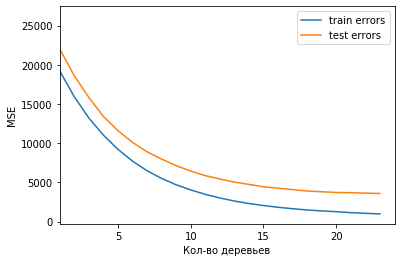

In [20]:
res_train, res_test = [], []
n_trees_array = np.arange(1, 25)
for i in n_trees_array:
    coefs = [1] * n_trees
    trees, train_errors, test_errors = gb_fit(i, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    mse_train, mse_test = evaluate_alg_my(X_train, X_test, y_train, y_test, trees, coefs, eta)
    res_train.append(mse_train)
    res_test.append(mse_test)

plt.xlim(1, len(n_trees_array))
plt.plot(res_train, label='train errors')
plt.plot(res_test, label='test errors')
plt.xlabel('Кол-во деревьев')
plt.ylabel('MSE')
plt.legend(loc='upper right')

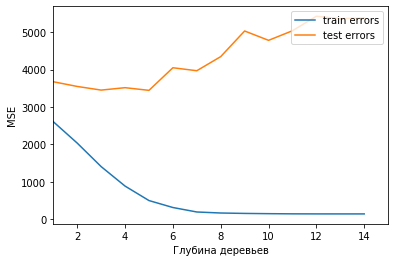

In [13]:
coefs = [1] * n_trees

res_train, res_test = [], []
depth_array = np.arange(1, 16)
for i in depth_array:
 
    trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)
    mse_train, mse_test = evaluate_alg_my(X_train, X_test, y_train, y_test, trees, coefs, eta)
    res_train.append(mse_train)
    res_test.append(mse_test)

plt.xlim(1, len(depth_array))
plt.plot(res_train, label='train errors')
plt.plot(res_test, label='test errors')
plt.xlabel('Глубина деревьев')
plt.ylabel('MSE')
plt.legend(loc='upper right')

При увеличении количества деревьев в лесу качество обучения улучшается, а при увеличением глубины деревьев точность незначительно возрастает и быстро переходит в переобучение.

#### 2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [14]:
from random import randint

# Получаем случайным образом индексы фич для стохастического бустинга и возвращаем соответствующие данные
def get_random_sample_my(data): 
    n = data.shape[0]
    train_ind = set()  # Будем следить за тем, чтобы у нас на каждом шаге получалась половина всех строк 
    while len(train_ind) < n // 2:
        train_ind.add(randint(0, n - 1))
    # так же заполним индексы, корорые не попали в обучающую выборку
    test_ind = set(np.arange(0, n)).difference(set(train_ind))

    return np.array(list(train_ind)).astype(int), np.array(list(test_ind)).astype(int)

In [15]:
# добавим индексы
def gb_predict_st(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [16]:
def evaluate_alg_my2(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict_st(X_train, trees, coefs, eta)
    test_prediction = gb_predict_st(X_test, trees, coefs, eta)

    return mean_squared_error(y_train, train_prediction), mean_squared_error(y_test, test_prediction)

In [17]:
# обучение на подвыборке
def gb_fit_st(n_trees, max_depth, X, y, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        # на каждом шаге обновляем индексы
        train_indexes, test_indexes = get_random_sample_my(X)
        data_train, labels_train = X[train_indexes], y[train_indexes]
        data_test, labels_test = X[test_indexes], y[test_indexes]

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        
        if len(trees) == 0:

            # обучаем первое дерево на обучающей выборке
            tree.fit(data_train, labels_train)
            
            train_errors.append(mean_squared_error(labels_train, gb_predict_st(data_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(labels_test, gb_predict_st(data_test, trees, coefs, eta)))

        else:
            # Получим ответы на текущей композиции
            target = gb_predict_st(data_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(data_train, bias(labels_train, target))
            
            train_errors.append(mean_squared_error(labels_train, gb_predict_st(data_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(labels_test, gb_predict_st(data_test, trees, coefs, eta)))
            
            
        trees.append(tree)
        
    return trees, train_errors, test_errors

In [18]:
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit_st(n_trees, max_depth, X, y, coefs, eta)

evaluate_alg_my2(X_train, X_test, y_train, y_test, trees, coefs, eta)

(1362.35428106129, 1567.0790265667897)

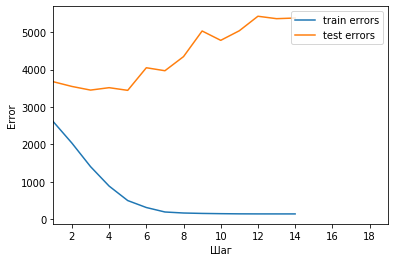

In [19]:
# Построим график зависимости ошибок от шага
eta_list = np.arange(0.05, 1, 0.05)
train_err, test_err = [], []
for i in eta_list:
    train_errors, test_errors = evaluate_alg_my2(X_train, X_test, y_train, y_test, trees, coefs, i)

plt.xlim(1, len(eta_list))
plt.plot(res_train, label='train errors')
plt.plot(res_test, label='test errors')
plt.xlabel('Шаг')
plt.ylabel('Error')
plt.legend(loc='upper right')